# Setup

In [1]:
import pyphi
import numpy as np
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize

In [2]:
import warnings
warnings.filterwarnings("ignore")
# UNCOMMENT ABOVE TO CHECK DEPRECATIONS

In [3]:
%matplotlib inline

In [4]:
import pixiedust

Pixiedust database opened successfully


In [5]:
pyphi.config.PROGRESS_BARS = False

## Immutables

In [6]:
RAW_DATA_DIR = "../data/raw/"
SAMPLE_DATA_FILE = "split2250_bipolarRerefType1_lineNoiseRemoved_postPuffpreStim.mat"

In [7]:
FLY_DATA = sio.loadmat(RAW_DATA_DIR + SAMPLE_DATA_FILE).get("fly_data")

# Processing Functions

In [49]:
def gen_log_reg(data, tau=1):
    """ Generate logistic regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
        tau (int): Time lag between present and next state.
                      
    Returns: 
        List of Logistic regressions (fitted) for each channel.
    """
    
    n_timepoints, n_channels, n_trials = data.shape
    
    presents = data[:n_timepoints - tau, :, :]\
                .transpose(2, 0, 1)\
                .reshape((n_trials * (n_timepoints - tau), n_channels))
    nexts = data[tau:, :, :]\
                .transpose(2, 0, 1)\
                .reshape((n_trials * (n_timepoints - tau), n_channels))
    
    # TODO find faster way to construct dict
    data_dict = {"x{}".format(i_x): presents[:, i_x] for \
                i_x in range(n_channels)}
    
    patsy_str = "*".join(["x{}".format(i_x) for i_x in range(n_channels)])
    
    X_dmatrix = patsy.dmatrix(patsy_str, data_dict)
    Xs = X_dmatrix[:, 1:] # exclude intercept term
    
    models = []
    
    for i_c in range(n_channels):
        y = nexts[:, i_c]
        lr = LogisticRegression(solver='lbfgs')
        model = lr.fit(Xs, y)
        models.append(model)
    
    return models

In [50]:
def models_to_tpm(models, n_channels):
    """ Converts a logistic regression model to a TPM
    
    Args:
        models: List of fitted logistic regression models.
        n_channels (int): Number of channels used to generate model.
        
    Returns:
        A numpy array as a TPM.
    """
    
    tpm_shape = [2] * n_channels + [n_channels]
    
    tpm = np.zeros(tpm_shape)
    
    for state in itertools.product((0, 1), repeat=n_channels):
        for i_m, model in enumerate(models):
            state_arr = np.array(state)
            data_dict = {"x{}".format(i_x): state_arr[i_x] for \
                        i_x in range(n_channels)}
            patsy_str = "*".join(["x{}".format(i_x) for i_x in range(n_channels)])
            state_dmatrix = patsy.dmatrix(patsy_str, data_dict)
            state_interact = state_dmatrix[:, 1:]
            tpm[state + (i_m,)] = model.predict_proba(state_interact)[0][1]
    
    return tpm

In [51]:
def tpm_log_reg(data, tau=1):
    """ Generate tpm using log regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
                      
    Returns: 
        TPM for the input data.
    """
    
    _, n_channels, _ = data.shape
    
    return models_to_tpm(gen_log_reg(data, tau=tau), n_channels)

# Testing

## Generated Data (Deterministic)

In [52]:
def det_generate(tpm, n_timepoints, n_channels, n_trials):
    
    states = list(itertools.product((0, 1), repeat=n_channels))
    
    samples = np.zeros((1 + n_timepoints, n_channels, (2 ** n_channels) * n_trials))
    
    for i_s, state in enumerate(states * n_trials):
        samples[0, :, i_s] = np.array(state)
        
        for i_t in range(n_timepoints):
            curr_state = tuple(samples[i_t, :, i_s].astype(int))
            value = tpm[curr_state]
            samples[i_t + 1, :, i_s] = value
    
    return samples

In [53]:
test_shape = [2] * 3 + [3]
test_tpm = np.zeros(test_shape)

test_tpm[(0, 0, 0)] = np.array([0, 0, 0])
test_tpm[(0, 0, 1)] = np.array([1, 1, 0])
test_tpm[(0, 1, 0)] = np.array([1, 0, 1])
test_tpm[(0, 1, 1)] = np.array([1, 1, 1])
test_tpm[(1, 0, 0)] = np.array([0, 0, 1])
test_tpm[(1, 0, 1)] = np.array([1, 1, 1])
test_tpm[(1, 1, 0)] = np.array([1, 0, 0])
test_tpm[(1, 1, 1)] = np.array([1, 1, 0])

In [54]:
network_tpm_in = pyphi.Network(test_tpm)

In [55]:
test_state = (1, 0, 0)

In [56]:
subsystem_in = pyphi.Subsystem(network_tpm_in, test_state)

In [57]:
pyphi.compute.phi(subsystem_in)

2.3125

### 10 Trials

In [58]:
test_samples_10_trials = det_generate(test_tpm, 100, 3, 10)

In [59]:
out_tpm_10_trials = tpm_log_reg(test_samples_10_trials).round(decimals=1)

In [60]:
for state in itertools.product((0, 1), repeat=3):
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_10_trials[state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [0.9 0.  0.1]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.5]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


In [61]:
network_tpm_out_10 = pyphi.Network(out_tpm_10_trials)

In [62]:
subsystem_out_10 = pyphi.Subsystem(network_tpm_out_10, test_state)

In [63]:
pyphi.compute.phi(subsystem_out_10)

0.881276

### 100 Trials

In [64]:
test_samples_100_trials = det_generate(test_tpm, 100, 3, 100)

In [65]:
out_tpm_100_trials = tpm_log_reg(test_samples_100_trials).round(decimals=1)

In [66]:
for state in itertools.product((0, 1), repeat=3):
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_100_trials[state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [1.  0.  0.8]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.9]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


> As a note, it seems when the number of trials is low and a certain state does not occur frequently, the transition probability from that state is quite poorly estimated (as can be seen from the comparison from 10 trials and 50 trials above). 

In [43]:
network_tpm_out_100 = pyphi.Network(out_tpm_100_trials)

In [44]:
subsystem_out_100 = pyphi.Subsystem(network_tpm_out_100, test_state)

In [45]:
pyphi.compute.phi(subsystem_out_100)

1.779672

## Fly Data

In [29]:
FLY_DATA.shape

(2250, 15, 8, 13, 2)

The shape of the data corresponds to:

- 2250 time samples (at 1000Hz)
- 15 channels (bipolar re-referenced)
- 8 "trials" (from one trial cut into smaller trials)
- 13 flies
- 2 conditions (awake and anaesthetised respectively)

The reference paper is at https://doi.org/10.1523/ENEURO.0329-17.2018

In [30]:
n_samples, n_channels, n_trials, n_flies, n_conds = FLY_DATA.shape

Let's just subset some example data.

In [31]:
n_test_ch = 2

In [32]:
exdata = FLY_DATA[:, 0:n_test_ch, :, 0, :]

In [33]:
exdata.shape

(2250, 2, 8, 2)

This is already roughly in the shape we need it to be (except the last dimension).

### Binarisation

In [34]:
meds = [np.median(exdata[:, c, :, :]) for c in range(n_test_ch)]

In [35]:
meds

[-12.676574489555772, -24.131163939693938]

In [36]:
exdata_bins = [np.where(exdata[:, i_ch, :, :] > meds[i_ch], 1, 0) for i_ch in range(n_test_ch)]

In [37]:
exdata_bin = np.stack(exdata_bins, axis=1)

In [38]:
exdata_bin.shape

(2250, 2, 8, 2)

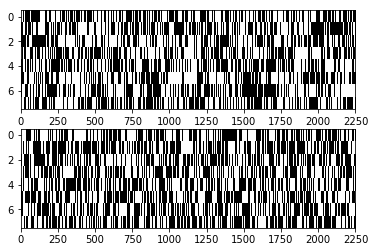

In [39]:
plt.subplot(211)
plt.imshow(exdata_bin[:, 0, :, 0].transpose(), aspect='auto', cmap='binary')
plt.subplot(212)
plt.imshow(exdata_bin[:, 0, :, 1].transpose(), aspect='auto', cmap='binary')

In [40]:
print(np.mean(exdata_bin[:, :, :, 0]))
print(np.mean(exdata_bin[:, :, :, 1]))

0.49344444444444446
0.5065555555555555


### Example Calculation: Per State

Let us try as an example:

- Median binarisation per channel per fly
- Time-bins of 4 samples
- For the first two channels
- For the first fly
- For BOTH awake and anaesthetised conditions

In [41]:
time_bin_width = 8

> TODO: How should the state be determined for a given bin? (currently just taking the mode for each node across all trials and all samples within a time bin)

In [42]:
%%time
# phis is (samples, conds) matrix of phi values
phis = np.zeros((n_samples - time_bin_width, n_conds))

for i_s in range(0, n_samples - time_bin_width, time_bin_width): # skip every time_bin_width for testing
    exdata_binned = exdata_bin[i_s:i_s+time_bin_width, :, :, :]
    
    for i_cond in range(n_conds):
        tpm = tpm_log_reg(exdata_binned[:, :, :, i_cond])
        network = pyphi.Network(tpm)
        state = np.array([stats.mode(exdata_binned[:, i_ch, :, i_cond], axis=None).mode for \
                       i_ch in range(n_test_ch)])
        state = state.flatten()
        subsystem = pyphi.Subsystem(network, state)

        phi = pyphi.compute.phi(subsystem)
        
        phis[i_s, i_cond] = phi
    
    if i_s % 100 == 0:
        print("SAMPLE AT TIME {} DONE".format(i_s))

SAMPLE AT TIME 0 DONE
SAMPLE AT TIME 200 DONE
SAMPLE AT TIME 400 DONE
SAMPLE AT TIME 600 DONE
SAMPLE AT TIME 800 DONE
SAMPLE AT TIME 1000 DONE
SAMPLE AT TIME 1200 DONE
SAMPLE AT TIME 1400 DONE
SAMPLE AT TIME 1600 DONE
SAMPLE AT TIME 1800 DONE
SAMPLE AT TIME 2000 DONE
SAMPLE AT TIME 2200 DONE
CPU times: user 36.4 s, sys: 31.5 s, total: 1min 7s
Wall time: 1min 45s


In [43]:
test_phi_file = "../data/processed/fly_phi_test"
np.save(test_phi_file, phis)
# phis = np.load(test_phi_file + ".npy")

In [44]:
phis

array([[0.000143, 0.012089],
       [0.      , 0.      ],
       [0.      , 0.      ],
       ...,
       [0.      , 0.      ],
       [0.007289, 0.00584 ],
       [0.      , 0.      ]])

In [45]:
means = np.mean(phis, axis=0)
print(means)

[0.00110212 0.00094659]


In [46]:
stds = np.std(phis, axis=0)
print(stds)

[0.00450499 0.00434083]


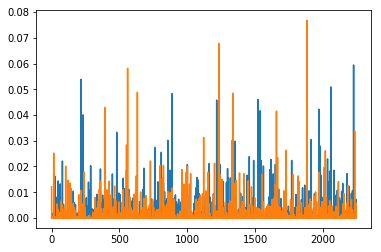

In [47]:
plt.plot(phis[:, 0])
plt.plot(phis[:, 1])

### Example Calculation: Across All Samples

In [48]:
tpms = [tpm_log_reg(exdata_bin[:, :, :, i]) for i in range(n_conds)]

In [49]:
networks = [pyphi.Network(tpm) for tpm in tpms]

In [50]:
print("NUMBER OF CHANNELS INCLUDED: {}".format(n_test_ch))

states = list(itertools.product((0, 1), repeat=n_test_ch))

for i_n, network in enumerate(networks):
    print("CONDITION {}\n----------".format(i_n))
    for state in states:
        subsystem = pyphi.Subsystem(network, state)
        print("STATE = {}, PHI = {}".format(state, pyphi.compute.phi(subsystem)))
    print("-----------\n\n")

NUMBER OF CHANNELS INCLUDED: 2
CONDITION 0
----------
STATE = (0, 0), PHI = 0.00367
STATE = (0, 1), PHI = 0.005275
STATE = (1, 0), PHI = 0.003518
STATE = (1, 1), PHI = 0.008638
-----------


CONDITION 1
----------
STATE = (0, 0), PHI = 0.004134
STATE = (0, 1), PHI = 0.000603
STATE = (1, 0), PHI = 0.000655
STATE = (1, 1), PHI = 0.005319
-----------




For a test run of 4 channels:

```

CONDITION 0
----------

STATE = (0, 0, 0, 0), PHI = 0.021758
STATE = (0, 0, 0, 1), PHI = 0.028135
STATE = (0, 0, 1, 0), PHI = 0.029401
STATE = (0, 0, 1, 1), PHI = 0.021155
STATE = (0, 1, 0, 0), PHI = 0.025647
STATE = (0, 1, 0, 1), PHI = 0.02143
STATE = (0, 1, 1, 0), PHI = 0.027238
STATE = (0, 1, 1, 1), PHI = 0.022308
STATE = (1, 0, 0, 0), PHI = 0.021724
STATE = (1, 0, 0, 1), PHI = 0.027762
STATE = (1, 0, 1, 0), PHI = 0.02208
STATE = (1, 0, 1, 1), PHI = 0.025907
STATE = (1, 1, 0, 0), PHI = 0.012662
STATE = (1, 1, 0, 1), PHI = 0.020735
STATE = (1, 1, 1, 0), PHI = 0.023346
STATE = (1, 1, 1, 1), PHI = 0.029959
-----------


CONDITION 1
----------

STATE = (0, 0, 0, 0), PHI = 0.007771
STATE = (0, 0, 0, 1), PHI = 0.013678
STATE = (0, 0, 1, 0), PHI = 0.014339
STATE = (0, 0, 1, 1), PHI = 0.006793
STATE = (0, 1, 0, 0), PHI = 0.009207
STATE = (0, 1, 0, 1), PHI = 0.005924
STATE = (0, 1, 1, 0), PHI = 0.011182
STATE = (0, 1, 1, 1), PHI = 0.003663
STATE = (1, 0, 0, 0), PHI = 0.004655
STATE = (1, 0, 0, 1), PHI = 0.008968
STATE = (1, 0, 1, 0), PHI = 0.011975
STATE = (1, 0, 1, 1), PHI = 0.007841
STATE = (1, 1, 0, 0), PHI = 0.00485
STATE = (1, 1, 0, 1), PHI = 0.013608
STATE = (1, 1, 1, 0), PHI = 0.012587
STATE = (1, 1, 1, 1), PHI = 0.008769
-----------
```
